# Transitions NREM-REM

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

# Utils Functions

In [3]:
def transition(states, template,epsilon = 0):
    '''
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any transition in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    '''
    
    long = pd.DataFrame()
    for s,i in states.items():
        i['state'] = s
        long = pd.concat((i,long))
        del i['state']
    order = np.argsort(long.start)
    long = long.iloc[order]
    
    transition_times = []
    transition_intervals = []
    for i,s in enumerate(long.state):
        tmp = list(long.state[i:i+len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i:i+len(template)]
#             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start)/1_000_000
            if np.any(length.values<epsilon): 
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre,tmp_post],0)
            
            
            transition_intervals.append([tmp_transition.start.iloc[0],tmp_transition.end.iloc[-1]])
            transition_times.append(tmp_times)
    
    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(start = transition_intervals[:,0],end = transition_intervals[:,1],force_no_fix = True)
    return transition_intervals,transition_times

## Computing

In [4]:
def sanity_check(neurons,states,intervals,timing):
#     plt.ioff()
    f = plt.figure(figsize=(12,4),dpi = 300)
    ax = plt.subplot(3,1,1)
    plt.suptitle(f'Rat : {bk.load.rat} Day : {bk.load.day} - {bk.load.session}')
    
    for k,s in states.items():
        if   k == 'Rem'    : c = 'orange'
        elif k == 'sws'    : c = 'grey'
        elif k == 'wake'   : c = 'pink'
        elif k == 'drowsy' : c = 'green'
            
        bk.plot.intervals(s,c)

    
    plt.subplot(3,1,2,sharex = ax)
    bk.plot.intervals(intervals)
    for i in timing.ravel(): plt.axvline(i/1_000_000)

    plt.subplot(3,1,3,sharex = ax)
    bk.plot.rasterPlot(neurons)
    plt.tight_layout()
    
#     plt.savefig(f'/home/billel/figs/{bk.load.session}.jpeg')
#     f.clear()
#     plt.close(f)
#     lfp = bk.load.loadLFP()
#     plt.subplot(4,1,4,sharex = ax)
#     plt.plot(lfp.as_units('s'))
    

In [5]:
def compute_transition_activity(neurons,intervals,timing,bin_epochs,n_event):
    
    transition_activity = []
    for event,t in zip(intervals.iloc,timing): #For each transitions
        if n_event == 2: epochs = np.array([(event.start,t[0]),(t[0],event.end)],dtype = np.int64)
        if n_event == 3 :epochs = np.array([[event.start,t[0]],[t[0],t[1]],[t[1],event.end]])
        epochs = nts.IntervalSet(start = epochs[:,0],end = epochs[:,1])
        #Creates intervals for each state of the transitions events.


#         binned = np.array(shape = (252,np.sum(bin_epochs)))
#         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
        binned = np.empty(shape = (len(neurons),1))
        for i,epoch in enumerate(epochs.as_units('s').iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            _,b = bk.compute.binSpikes(neurons,start = start,stop = end,nbins=nbins)
            b = b/((end-start)/nbins) # Converting to firing rates

            binned = np.hstack((binned,b))
        binned = binned[:,1:]
        transition_activity.append(binned)

    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity,0,2)
    
    return transition_activity

In [6]:
def main(local_path = 'Rat08/Rat08-20130713',arg = None,plot = False, save = False):
    #Variables :
    if arg == None:
        transition_interest = [['Rem','sws','Rem']] #Template of transitions to follow.
        bin_epochs = [12,30,12]
        n_event = 3
    else:
        transition_interest = [arg[0]]
        bin_epochs = arg[1]
        n_event = arg[2]
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    for i,transition_name in enumerate(transition_interest): #For each kind of transitions
        print(f'Computing {transition_name} transitions')
        intervals,timing = transition(states,transition_name,epsilon=50) #Find the timing of the transitions
        print(f'Found {len(intervals)} transitions')
        
        transition_activity = compute_transition_activity(neurons,intervals,timing,bin_epochs,n_event)

        if plot:
            print(np.mean(transition_activity[metadata.Region == "BLA"],2).T.shape)
            y_bla = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "BLA"],2).T,0)
            y_hpc = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0)

            plt.figure()
            plt.plot(y_bla,'green')
            plt.plot(y_hpc,'blue')

            plt.title(f'Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}')
        print(os.getcwd())
        # sanity_check(neurons,states,intervals,timing)
        return np.array(transition_activity),metadata

In [7]:
def NREM_Control(local_path = 'Rat08/Rat08-20130713',arg = None ,plot = False, save = False):
    
    NREM_length = 250
    REM_length = 80*1_000_000
    bin_epochs = [30,12,30]
    
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    
    intervals,_ = transition(states,['sws'],NREM_length)
    m = (intervals.start+intervals.end)/2 
    timing = np.array([m-(REM_length/2),m+(REM_length/2)]).T
    print(f'Found {len(intervals)} transitions')
    
    transition_activity = compute_transition_activity(neurons,intervals,timing,bin_epochs)
#     sanity_check(neurons,states,intervals,timing)
    
    return np.array(transition_activity),metadata

In [8]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [ ]:
arg = [['sws','Rem'],[30,12],2]
NREM_REM = bk.load.batch(main,arg,verbose=False,linux=True)

  2%|▏         | 1/61 [00:03<03:32,  3.54s/it]

Loading Data from Rat08-20130709
Rat : 8 on day : 2
Working with session Rat08-20130709 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
Rat08-20130709-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 12 transitions


In [9]:
arg = [['sws','Rem','sws'],[30,12,30],3]
NREM_REM_NREM = bk.load.batch(main,arg,verbose=False,linux=True)
arg = [['Rem','sws','Rem'],[12,30,12],3]
REM_NREM_REM = bk.load.batch(main,arg,verbose=False,linux=True)
arg = None
NREM_Control = bk.load.batch(NREM_Control,arg,verbose=False,linux=True)

100%|██████████| 61/61 [04:01<00:00,  3.96s/it]

Batch finished in 241.37935042381287
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


 ## Merging

In [10]:
def merge(batch,name,discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
#          if True:
            transitions_activity.append(np.mean(b[0],2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,'average_transition':np.vstack(transitions_activity),'metadata':pd.concat(metadata),'n_transitions':n_transitions,'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [11]:
discard = ['Rat08-20130718','Rat09-20140408','Rat09-20140409','Rat10-20140619','Rat10-20140620','Rat10-20140622']

In [ ]:
m_NREM_REM = merge(NREM_REM,'NREM_REM',discard)

In [12]:
m_NREM_REM_NREM = merge(NREM_REM_NREM,'NREM_REM_NREM',discard)
m_REM_NREM_REM = merge(REM_NREM_REM,'REM_NREM_REM',discard)
m_NREM_Control = merge(NREM_Control,'NREM Control',discard)

## Plotting

In [35]:
%matplotlib qt

## NREM-REM Transition

In [ ]:
stru = ['Hpc','BLA','Pir','CeCM']
transition = m_NREM_REM

for s in stru:
    fig,ax = plt.subplot_mosaic('''
                                   ABD
                                   ABD
                                   ABE
                                   FCE
                                ''')
    metadata = m_NREM_REM['metadata']
    stru_mask = metadata.Region == s
    pyr_mask = metadata.Type == 'Pyr'
    int_mask = metadata.Type == 'Int'
    
    average_stru_pyr = m_NREM_REM['average_transition'][stru_mask & pyr_mask]
    average_stru_int = m_NREM_REM['average_transition'][stru_mask & int_mask]
    
    z_average_stru_pyr = zscore(average_stru_pyr,1)
    z_average_stru_int = zscore(average_stru_int,1)

    mean_pyr_fr_sleep = np.mean(average_stru_pyr,1)
    
    ax['A'].plot(np.mean(average_stru_int,0),'--',color = 'black')
    quantiles = pd.qcut(mean_pyr_fr_sleep,5)
    for q in quantiles.categories:
        ax['A'].plot(np.mean(average_stru_pyr[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)].T,1))
        ax['F'].axvline(np.log(q.left),color = 'red')
    ax['A'].axvspan(30,41,color = 'orange',alpha = 0.5)
    ax['A'].set_xlabel('Time (Normalized)')
    ax['A'].set_ylabel('Firing Rates (log)')
    
    l = np.log(mean_pyr_fr_sleep)
    l[np.isinf(l)] = np.nan
    ax['F'].hist(l,50)
    ax['F'].set_xlim([-4,4])
    ax['F'].set_xlabel('log FR')
    ax['F'].set_ylabel('Count')
    
    im = ax['B'].imshow(z_average_stru_pyr[~np.isnan(z_average_stru_pyr[:,0]),:],aspect = 'auto')  
    im.set_clim([-3,3])
    ax['B'].set_ylabel('#Neurons')
    ax['B'].set_xlabel('Time (Normalized)')
    plt.title('Pyr')

    im = ax['C'].imshow(z_average_stru_int[~np.isnan(z_average_stru_int[:,0]),:],aspect = 'auto')
    im.set_clim([-3,3])
    ax['C'].set_xlabel('Time (Normalized)')
    ax['C'].set_ylabel('#Neurons')
    plt.title('Int')


    z_average_stru_pyr = zscore(average_stru_pyr,0)
    
    
    
    ### Violin plot
    mean_pre_pyr = np.mean(z_average_stru_pyr[:,0:30],1)
    mean_post_pyr = np.mean(z_average_stru_pyr[:,30:41],1)
    
    mean_pre_int = np.mean(z_average_stru_int[:,0:30],1)
    mean_post_int = np.mean(z_average_stru_int[:,30:41],1)

    df_pyr = pd.DataFrame(np.array([mean_pre_pyr,mean_post_pyr]).T,columns=['PRE','POST'])
    df_int = pd.DataFrame(np.array([mean_pre_int,mean_post_int]).T,columns=['PRE','POST'])
    
    
    plt.sca(ax['D'])
    sns.violinplot(data = df_pyr)
    ax['D'].set_ylim([-3, 3])
    plt.title('Pyr')

    plt.sca(ax['E'])
    sns.violinplot(data = df_int)
    plt.title('Int')

    
    plt.suptitle(s)
    plt.tight_layout()
    
    plt.savefig(f'/home/billel/figs/{s}.svg')

## NREM-REM-NREM

BLAPyr
(1081,)
3.707144600425096e-11


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


BLAInt
(168,)
0.10417318452728529
0.10417
CeCMInt
(517,)
0.0010759405172015265
HpcPyr
(697,)
3.4075845331694514e-15


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcInt
(93,)
1.3565762990303421e-05
PirPyr
(810,)
0.0009518387316897871
PirInt
(86,)
0.6280845234540531


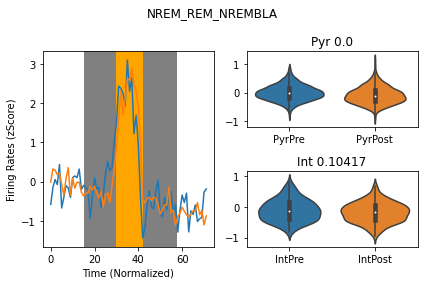

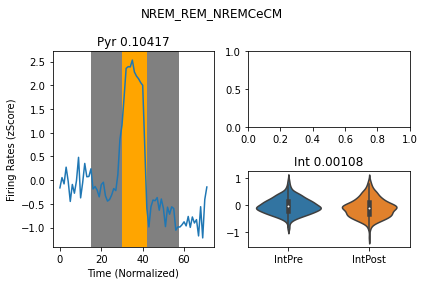

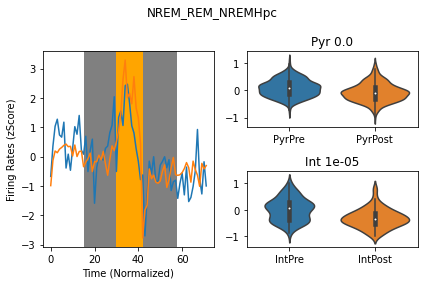

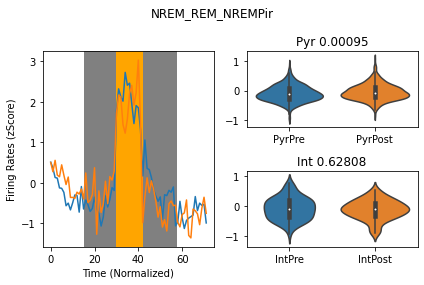

In [39]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_NREM_REM_NREM]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,15:30],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:42+15],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(15,30,color = 'grey')
                ax['A'].axvspan(30,30+12,color = 'orange')
                ax['A'].axvspan(42,42+15,color = 'grey')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)

                plt.suptitle(trans['name']+s)
            print(p)
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

## NREM Control

BLAPyr
(1735,)
1.5260359414928126e-25


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


BLAInt
(257,)
4.061079281639934e-21
0.0
CeCMInt
(707,)
3.455011784364892e-05
HpcPyr
(932,)
8.82534155634023e-41


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcInt
(130,)
7.020371306169866e-13
PirPyr
(944,)
2.463549029574644e-35
PirInt
(99,)
1.0088285959367005e-09


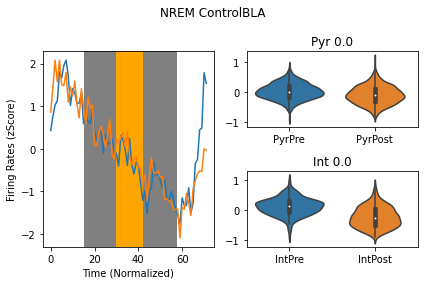

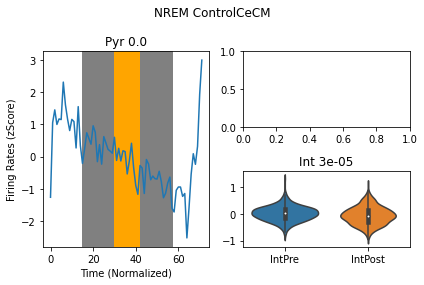

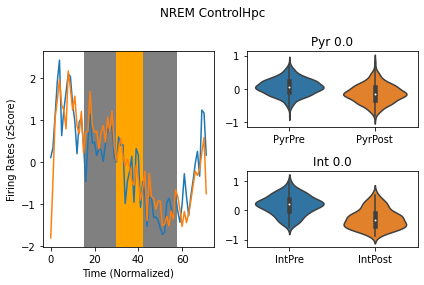

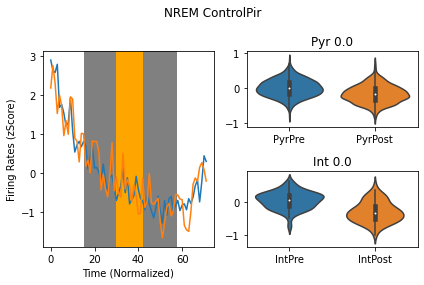

In [40]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_NREM_Control]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,15:30],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:42+15],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(15,30,color = 'grey')
                ax['A'].axvspan(30,30+12,color = 'orange')
                ax['A'].axvspan(42,42+15,color = 'grey')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)

                plt.suptitle(trans['name']+s)
            print(p)
            plt.title(f'{t}')
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

## REM_NREM_REM 

BLAPyr
(844,)
0.2691267645573422
BLAInt
(132,)
0.31106538490983604
0.31107
CeCMInt
(379,)
0.10297330693746189


/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


HpcPyr
(380,)
0.05860289063156927
HpcInt
(55,)
0.5026768557083605
PirPyr
(472,)
0.4402966921238851
PirInt
(60,)
0.49823626254144004


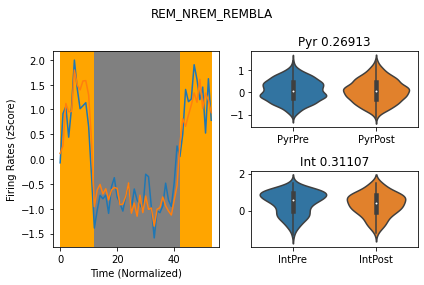

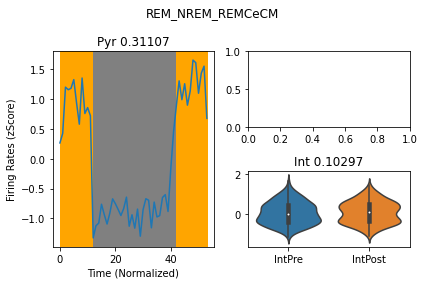

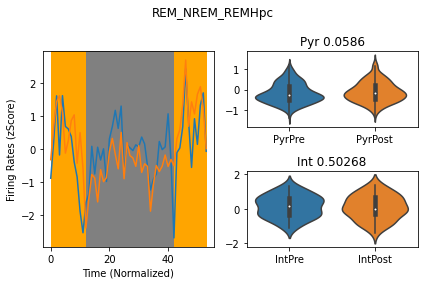

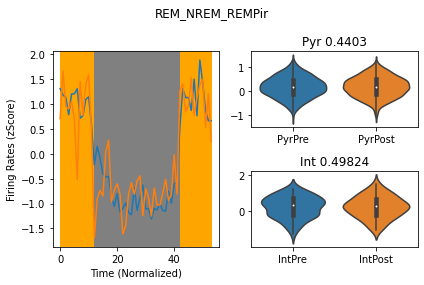

In [41]:
stru = ['BLA','CeCM','Hpc','Pir']
types = ['Pyr','Int']
transitions = [m_REM_NREM_REM]


for trans in transitions:
    for s in stru:
        fig,ax = plt.subplot_mosaic('''AB
                                       AC''')
        stru_mask = trans['metadata'].Region == s
        for t in types:
            types_mask = trans['metadata'].Type == t
            stru_type_activity = trans['average_transition'][(stru_mask) & types_mask]
            if np.any(stru_type_activity) :
                print(s+t)
                z_stru_type_activity = zscore(stru_type_activity,1)
                pre_fr = np.nanmean(z_stru_type_activity[:,0:12],1)
                post_fr = np.nanmean(z_stru_type_activity[:,42:],1)
                print(pre_fr.shape)
                a,p = scipy.stats.wilcoxon(pre_fr,post_fr)
                a = np.array([pre_fr,post_fr]).T
                v = pd.DataFrame(a,columns=[f'{t}Pre',f'{t}Post'])
                ax['A'].plot(zscore(np.mean(stru_type_activity.T,1)))
                ax['A'].axvspan(0,12,color = 'orange')
                ax['A'].axvspan(12,12+30,color = 'grey')
                ax['A'].axvspan(42,42+11,color = 'orange')
                ax['A'].set_xlabel('Time (Normalized)')
                ax['A'].set_ylabel('Firing Rates (zScore)')
                if t == 'Pyr':
                    plt.sca(ax['B'])
                    sns.violinplot(data = v)
                else:
                    plt.sca(ax['C'])
                    sns.violinplot(data = v)
                plt.suptitle(trans['name']+s)
            
            print(p)
            p = np.round(p,5)
            plt.title(f'{t} {p}')
            plt.tight_layout()
            name = trans['name']
            plt.savefig(f'/home/billel/Data/figs/{name}_{s}.svg')

In [38]:
for r,i in enumerate(['Hpc','CeCM','BLA','Pir']):
    plt.figure()
    for t,j in enumerate(['Pyr','Int'],1):
        stru_type_activity = transitions_activity[(metadata.Region == i) & (metadata.Type == j)]
        plt.subplot(1,2,t)
        if np.any(stru_type_activity):
#             order = np.argsort(np.mean(stru_type_activity[:,30:41],1)/np.mean(stru_type_activity,1))
            plt.title(f'Stru : {i} type : {j}')
            plt.imshow(stru_type_activity[:,:],aspect='auto');
            plt.clim([-5,5])
    plt.tight_layout()

NameError: name 'transitions_activity' is not defined

<Figure size 432x288 with 0 Axes>

In [141]:
metadata[metadata.Region == 'Hpc']

,Rat,Day,Shank,Id,Region,Type
0,8,1,4,2,Hpc,Pyr
1,8,1,4,3,Hpc,Pyr
2,8,1,4,4,Hpc,Int
3,8,1,4,5,Hpc,Pyr
4,8,1,4,6,Hpc,Pyr
...,...,...,...,...,...,...
73,11,20,18,15,Hpc,Int
74,11,20,20,2,Hpc,Pyr
75,11,20,20,3,Hpc,Pyr
76,11,20,20,4,Hpc,Pyr


In [67]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [68]:
states = bk.load.states()

In [69]:
transition(states,['sws'])

(          start          end
 0    1448000000   1697000000
 1    1777000000   1926000000
 2    2104000000   2429000000
 3    2826000000   3275000000
 4    3383000000   3841000000
 5    3888000000   3916000000
 6    3970000000   3992000000
 7    4024000000   4529000000
 8    4568000000   4648000000
 9    5044000000   5426000000
 10   5489000000   6069000000
 11   6368000000   6629000000
 12   6970000000   7311000000
 13   7375000000   7759000000
 14   7788000000   7909000000
 15   8485000000   8797000000
 16   8887000000   9333000000
 17  15516000000  16145000000
 18  16436000000  16765000000
 19  16801000000  17259000000
 20  17364000000  17429000000
 21  17497000000  17669000000
 22  17689000000  17764000000
 23  17791000000  17810000000
 24  17852000000  18076000000
 25  18132000000  18528000000
 26  18663000000  18979000000
 27  19086000000  19167000000
 28  19187000000  19448000000
 29  19546000000  19771000000
 30  19818000000  20363000000
 31  20867000000  21286000000
 32  21359

In [4]:
# transition_interest = [('Rem','sws'),('sws','Rem'),('Rem','wake')]
# s = "ABC"
# fig,ax = plt.subplot_mosaic('ABC')
# for ii,i in enumerate(transition_interest):
#     binned = []
#     for event,trans_time in zip(transitions[i].as_units('s').iloc,times[i].as_units('s').index.values):
#         print(trans_time)
#         print('he')
#         start = event.start
#         end = event.end
        
#         if (end-trans_time)<50 or (trans_time-start) <50: continue
# #         if (end-trans_time) > 180: end = trans_time+120
# #         if (trans_time-start) > 180: start = trans_time-120
        
        
        
#         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
#         t_post,b_post = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
#         b_pre = b_pre/((trans_time-start)/30)
#         b_post = b_post/((end-trans_time)/12)
#         t = np.hstack((t_pre,t_post))
#         b = np.hstack((b_pre,b_post))
        
# #         plt.figure()
# #         plt.plot(t,b.T)
# #         plt.axvline(trans_time,color = 'red')
#         binned.append(b)
#     ax[s[ii]].plot(np.mean(binned,0).T)
    
# plt.suptitle('Transition')